In [100]:
import pandas as pd
import numpy as np
from copy import deepcopy
import pickle
import cvxpy 
from cvxpy import *
from  sklearn.preprocessing import Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import sys

In [2]:
# plt.style.use('default')
plt.rcParams.update({'font.size':16})
figDir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NSBA_submission/figures/'
my_cmap = sns.diverging_palette(15, 221, s=99, sep=1, l=45, center='light',as_cmap=True)
# sns.choose_diverging_palette()

In [3]:
def snapshots_from_df(df):

    strains = ['wt','icar','phlf','nand']
    tps = ['5','18']
    temps = ['30','37']
    inducers = ['00','10','01','11']

    # create a dictionary where you specify strain, temp, and inducers as keys to grab the snapshot matrices
    snapshot_dict = {}
    for strain in strains: 
        snapshot_dict[strain] = {}
        for temp in temps: 
            snapshot_dict[strain][temp] = {}
            for inducer in inducers: 
                snapshot_dict[strain][temp][inducer] = {} # keys are to be Yf and Yp
                # get substring of colname that identifies the group (so everything except rep number)
                yp_colname = strain + '_' + inducer + temp + tps[0]
                # get list of indices that correspond to this group (in short, grabbing inds for all replicates)
                yp_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yp_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yp'] = np.array(df.iloc[:,yp_col_inds])
                # do the same for the 18 hours timepoint i.e. Yf
                yf_colname = strain + '_' + inducer + temp + tps[1]
                yf_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yf_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yf'] = np.array(df.iloc[:,yf_col_inds])
                
    return snapshot_dict

def get_unpaired_samples(df):
    # filter the samples that don't have a timepoint pair due to low sequencing depth
    unpaired_samples = []
    for sample in df.columns: 
        if '5' in sample:
            if sample.replace('5','18') not in df.columns:
                unpaired_samples.append(sample)
        elif '18' in sample: 
            if sample.replace('18','5') not in df.columns:
                unpaired_samples.append(sample)
    return unpaired_samples

def apply_normalizer(Yp,Yf):
    # normalize each datapoint to have unit norm
    transformer1 = Normalizer().fit(Yp.T)
    Yp_normed = transformer1.transform(Yp.T).T

    transformer2 = Normalizer().fit(Yf.T)
    Yf_normed = transformer2.transform(Yf.T).T
    return Yp_normed,Yf_normed

def calc_Koopman(Yf,Yp,flag=1,lambda_val=0.0,noise_scaler=1,verbose=True):
    ngenes = Yf.shape[0]
    ndatapts = Yf.shape[1]
    
    if flag == 1: # least-squares solution
        Yp_inv = np.linalg.pinv(Yp)
        K = np.dot(Yf,Yp_inv)
        print('The mean squared error is: ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 
        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # robust optimization approach
        solver_instance = cvxpy.SCS
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1) 
        else:
            lambda_val = lambda_val[:,np.newaxis]
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') # where exactly does this term come from?  

        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)
        print('MSE =  ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 
        print('\n','\n')

    return K

def calc_retroactivity_and_impact(Yf,Yp,Khh,circuit_inds,lambda_val=0.0,noise_scaler=1,verbose=True):
    
    ngenes = Yp.shape[0]
    ndatapts = Yp.shape[1]
    ncircuitgenes = len(circuit_inds)
    
    solver_instance = cvxpy.SCS
    
    Khc = Variable(shape=(ngenes-ncircuitgenes,ncircuitgenes)) # circuit impact on host
    Kch = Variable(shape=(ncircuitgenes,ngenes-ncircuitgenes)) # retroactivity (host impact on circuit)
#     Kch = np.zeros((ncircuitgenes,ngenes-ncircuitgenes))
    Kcc = Variable(shape=(ncircuitgenes,ncircuitgenes))
    lowerK = cvxpy.hstack((Khc,Khh))
    upperK = cvxpy.hstack((Kcc,Kch))
    operator = cvxpy.vstack((upperK,lowerK))

    print("[INFO]: CVXPY Khc variable: " + repr(Khc.shape))
    print("[INFO]: CVXPY Kch variable: " + repr(Kch.shape))
    print("[INFO]: CVXPY Kcc variable: " + repr(Kcc.shape))
    print("[INFO]: CVXPY operator variable: " + repr(operator.shape))

    if type(lambda_val) == float:
        reg_term = lambda_val*( cvxpy.norm(Khc,p=1) + cvxpy.norm(Kch,p=1) + cvxpy.norm(Kcc,p=1))
#         reg_term = lambda_val*( cvxpy.norm(Kch,p=1) + cvxpy.norm(Kch,p='fro') )
    else:
        lambda_val = lambda_val[:,np.newaxis]
        Unoise = np.tile(lambda_val,ndatapts)
        reg_term = cvxpy.norm(cvxpy.matmul(operator,noise_scaler*Unoise),p='fro') 
    
    norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp), p=2)
    objective = Minimize(norm2_fit_term + reg_term)
    constraints = []
    prob = Problem(objective,constraints)
    result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
    Kstar = operator.value

    print("[INFO]: CVXPY problem status: " + prob.status)
    print('MSE =  ' + '{:0.3e}'.format(np.linalg.norm(Yf - Kstar@Yp)**2 / ndatapts)) 
    print('\n','\n')

    return Kstar

def get_ara_lac_genes(all_genes_filter):
    '''
    all_genes_filter: list of gene names in same order as df_tpm_filter
    '''
    lac_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
    ara_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
    lac_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
    ara_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
    my_genes = ara_genes + lac_genes
    my_inds = ara_inds + lac_inds
    return my_genes, my_inds

def get_DE_genes(res_dir_list,all_genes_filter,p_thresh=0.05,fc_thresh=2): 
    '''
    res_dir_list: list of directories for where to find DE results from DESeq2    

    '''
    res_list = []
    for res_dir in res_dir_list:  
        res_df = pd.read_csv(res_dir)
        # first filter by padj
        filter_p = res_df.loc[res_df.padj <  p_thresh]
        # next by FC
        res_filter_df  = filter_p.loc[np.abs(filter_p.log2FoldChange)>=\
                                                    np.log2(fc_thresh)]
        res_list.append(res_filter_df)

    # take the union of the genes remaining in each condition
    genes_DE = set()
    for res in res_list: 
        genes_DE = genes_DE.union(res.iloc[:,0]) # the first row contains gene names
    genes_DE = list(genes_DE)

    my_inds = [ii for ii,this_gene in enumerate(all_genes_filter) \
               for jj,DE_gene in enumerate(genes_DE) if  DE_gene == this_gene]
    my_genes = [all_genes_filter[ii] for ii in my_inds]

    return my_genes, my_inds

In [4]:
# Load TPM or GeTMM dataframe (results are identical, implying GeTMM normalization is unnecessary for our dataset)
df_tpm_filter = pd.read_csv('data/TPM_matrix_NAND.csv') # suffix is 'filter' because very low count genes have already been removed
# get list of samples that are to be removed because they don't have a timepoint pair, 
# i.e. a col in Xp does not have corresponding col in Xf or vice versa
unpaired_samples = get_unpaired_samples(df_tpm_filter)
# get gene names
all_genes_filter =  df_tpm_filter['gene'] 
# remove 'gene' col from df
df_tpm_filter = df_tpm_filter.iloc[:,1:]
# drop the unpaired samples
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)

# path to deseq results for gene downselection 
res_dir_list = ['data/condition_nand00375_vs_wt00375_results.csv',\
                'data/condition_nand003718_vs_wt003718_results.csv']

# get all snapshots keyed in the following way: 
# [strain][temperature][inducer][snapshots]
snapshot_dict = snapshots_from_df(df_tpm_filter)

# get circuit gene names and indices
circuit_inds = list(range(13)) # circuit genes are in first 13 rows of df
circuit_genes = all_genes_filter[:13]

# select genes for modeling
ara_lac = True # 13 ara and lac genes
de_only = False # only differentially expressed genes

# get host gene names and indices
if ara_lac:
    p_thresh, fc_thresh = 'n/a', 'n/a'
    my_genes,  my_inds  = get_ara_lac_genes(all_genes_filter) # only ara and lac genes, want to create more smaller networks like this:
    my_genes = list(all_genes_filter[circuit_inds]) + my_genes
    my_inds = circuit_inds + my_inds
    selected_genes = 'ara_lac'
# see: https://www.weizmann.ac.il/mcb/UriAlon/e-coli-transcription-network#:~:text=E.-,coli%20transcription%20network,in%20cells%20orchestrate%20gene%20expression.&text=Each%20network%20motif%20has%20a,responses%20to%20fluctuating%20external%20signals.
elif de_only: 
    p_thresh, fc_thresh = 0.05, 2.0
    my_genes, my_inds = get_DE_genes(res_dir_list,all_genes_filter,p_thresh=p_thresh,fc_thresh=fc_thresh)
    my_genes = list(all_genes_filter[circuit_inds]) + my_genes
    my_inds = circuit_inds + my_inds
    selected_genes = 'de_only'

TEMP = '37'
NOISE_SCALER = 10 # parameter that controls sparsity
VERBOSE = True

In [5]:
################# Wild type dynamics ###################################
Yp = snapshot_dict['wt'][TEMP]['11']['Yp']
Yf = snapshot_dict['wt'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds[len(circuit_inds):]], Yf_normed[my_inds[len(circuit_inds):]]
# compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)
K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.64e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.80e-01  1.27e+00  2.27e-01 -2.92e-01  1.82e-03  1.17e-16  1.49e-03 
    12| 1.59e-11  5.20e-11  3.80e-12  9.14e-13 -2.89e-12  1.68e-17  2.

In [6]:
########## Retroactivity and Impact on Host ####################################
Yp = snapshot_dict['nand'][TEMP]['11']['Yp']
Yf = snapshot_dict['nand'][TEMP]['11']['Yf']
# normalize each snapshot to have unit norm, a dynamics preserving transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds] # my_inds includes circuit genes, whereas in sdmd it does not
# # compute the intrareplicate noise for regularizing K as motivated by Robust DMD
lambda_val_vec_p = np.std(Yp_normed,axis=1)[:,np.newaxis]
lambda_val_vec_f = np.std(Yf_normed,axis=1)[:,np.newaxis]
lambda_val_vec = np.std(np.hstack((lambda_val_vec_p,lambda_val_vec_f)),axis=1)
# lambda_val_vec[-len(my_inds[len(circuit_inds):]):] = 0.0 # set host gene noise to zero 
Ktot = calc_retroactivity_and_impact(Yf_normed,Yp_normed,K,circuit_inds,lambda_val=lambda_val_vec,\
    noise_scaler=NOISE_SCALER,verbose=VERBOSE)

[INFO]: CVXPY Khc variable: (13, 13)
[INFO]: CVXPY Kch variable: (13, 13)
[INFO]: CVXPY Kcc variable: (13, 13)
[INFO]: CVXPY operator variable: (26, 26)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3931
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 509, constraints m = 570
Cones:	soc vars: 105, soc blks: 1
	sd vars: 465, sd blks: 1
Setup time: 1.53e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.25e-01  7.09e-01  8.86e-02 -9.69e-02  3.74e-04  1.36e-16  1.59e-03 
    16| 8.7

In [27]:
def koopman_heatmap(thisK,figsize,this_ax,xlabels,ylabels,shrink,savefig=False,savedir=''):
    hm = sns.heatmap(thisK,linewidths=1.0,cmap=my_cmap,xticklabels=xlabels,yticklabels=ylabels,
                linecolor='white',square=True,annot=False,annot_kws={"size":11},fmt='2.1f',
                     cbar_kws={'shrink':shrink},center=0,ax=this_ax)
    if thisK.shape[1] == 1: 
        plt.xticks(fontsize=20,rotation='horizontal');
    else: 
        plt.xticks(fontsize=20,rotation='vertical');
    plt.yticks(fontsize=18,rotation='horizontal')
    this_ax.axhline(y=0, color='k',linewidth=3)
    this_ax.axhline(y=thisK.shape[0], color='k',linewidth=3)
    this_ax.axvline(x=0, color='k',linewidth=3)
    this_ax.axvline(x=thisK.shape[1], color='k',linewidth=3)
    cax = fig.axes[-1]
    cax.set_frame_on(True)
    for spine in cax.spines.values():
        spine.set(visible=True, lw=1, edgecolor='k')
    plt.tight_layout()
    if savefig:
        plt.savefig(savedir,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

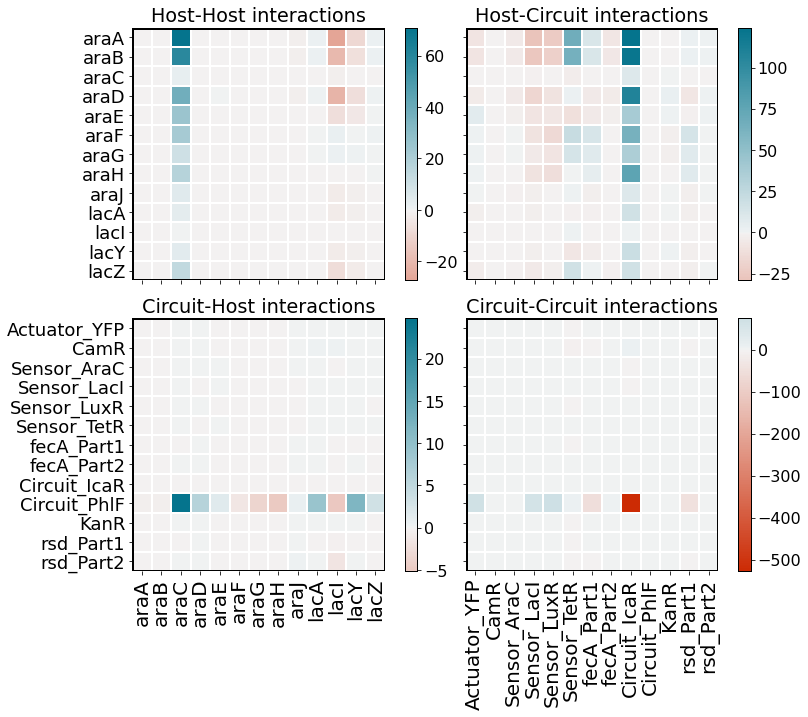

In [98]:
ncircuitgenes = 13
Khh = Ktot[-ncircuitgenes:,-ncircuitgenes:]
Khc = Ktot[-ncircuitgenes:,0:ncircuitgenes]
Kch = Ktot[0:ncircuitgenes,-ncircuitgenes:]
Kcc = Ktot[0:ncircuitgenes,0:ncircuitgenes]
Klist = [Khh,Khc,Kch,Kcc]
xlablist = [my_genes[ncircuitgenes:],my_genes[0:ncircuitgenes],my_genes[ncircuitgenes:],my_genes[0:ncircuitgenes]]
ylablist = [my_genes[ncircuitgenes:],my_genes[ncircuitgenes:],my_genes[0:ncircuitgenes],my_genes[0:ncircuitgenes]]
titles = ['Host-Host interactions','Host-Circuit interactions','Circuit-Host interactions','Circuit-Circuit interactions']
fig,ax = plt.subplots(2,2,figsize=(13,10),sharey='row',sharex='col')
for ii,this_ax in enumerate(ax.reshape(-1)): 
    sns.heatmap(Klist[ii],cmap=my_cmap,center=0,ax=this_ax,xticklabels=xlablist[ii],yticklabels=ylablist[ii],
               linewidths=1.0,linecolor='white',square=True)
    this_ax.set_title(titles[ii])
    this_ax.set_yticklabels(ylablist[ii],fontsize=18)
    this_ax.set_xticklabels(xlablist[ii],fontsize=20)
    this_ax.axhline(y=0, color='k',linewidth=3)
    this_ax.axhline(y=Klist[ii].shape[0], color='k',linewidth=3)
    this_ax.axvline(x=0, color='k',linewidth=3)
    this_ax.axvline(x=Klist[ii].shape[1], color='k',linewidth=3)
    cax = fig.axes[-1]
    cax.set_frame_on(True)
    for spine in cax.spines.values():
        spine.set(visible=True, lw=1, edgecolor='k')
plt.subplots_adjust(wspace=-0.15,hspace=0.15)
# plt.tight_layout()
# plt.savefig(figDir+'fig3/impact_and_retroactivity_lac_ara.pdf',transparent=True,bbox_inches='tight',dpi=300)
plt.show()